##### Content Analysis

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import ttest_ind

In [2]:
df = pd.read_excel('../data_processed/taliban_tweets-1.xlsx')

##### Prepapre text

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saboor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saboor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saboor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [8]:
sid = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['processed_text'].apply(lambda text: sid.polarity_scores(text))
df['sentiment'] = df['sentiment_scores'].apply(lambda scores: 'positive' if scores['compound'] > 0 else 'negative')


In [10]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(df['processed_text'])

feature_names = vectorizer.get_feature_names_out()
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=feature_names)


In [11]:
n_topics = 5  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
document_topics = lda_model.fit_transform(word_counts)

topic_names = [f"Topic {i+1}" for i in range(n_topics)]
document_topics_df = pd.DataFrame(document_topics, columns=topic_names)


In [12]:
positive_data = df[df['sentiment'] == 'positive']
negative_data = df[df['sentiment'] == 'negative']

positive_scores = positive_data['label']
negative_scores = negative_data['label']

t_statistic, p_value = ttest_ind(positive_scores, negative_scores)


In [13]:
# Descriptive statistics for the label variable
label_stats = df['label'].describe()

# Descriptive statistics for sentiment scores
df['positive_sentiment_score'] = df['sentiment_scores'].apply(lambda scores: scores['pos'])
df['negative_sentiment_score'] = df['sentiment_scores'].apply(lambda scores: scores['neg'])
sentiment_stats = df[['positive_sentiment_score', 'negative_sentiment_score']].describe()


In [15]:
# Perform additional statistical analysis as needed on other variables/columns

# Example: T-test between sentiment scores and label
t_statistic_sentiment, p_value_sentiment = ttest_ind(df['positive_sentiment_score'], df['negative_sentiment_score'])


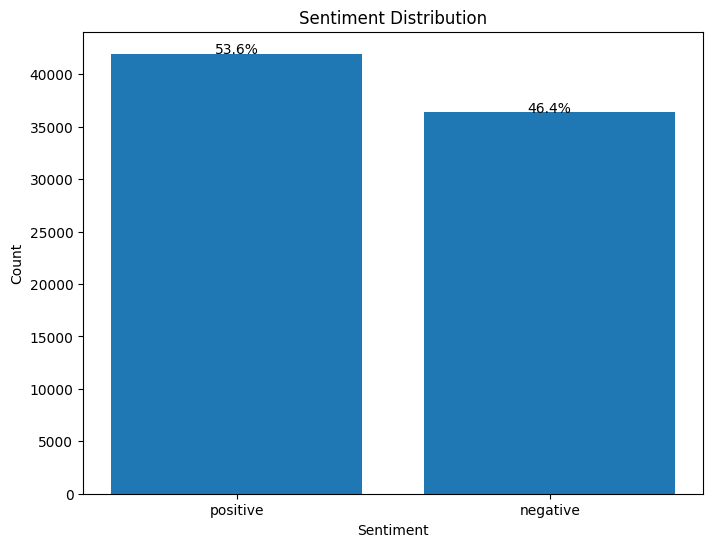

In [16]:
import matplotlib.pyplot as plt

# Visualization of sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / len(df) * 100

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Displaying percentages on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 1, f'{sentiment_percentages[i]:.1f}%', ha='center', fontsize=10)

plt.show()


In [17]:
# from wordcloud import WordCloud

# # Create word cloud from processed text
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['processed_text']))

# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Text Data')
# plt.show()


ModuleNotFoundError: No module named 'wordcloud'

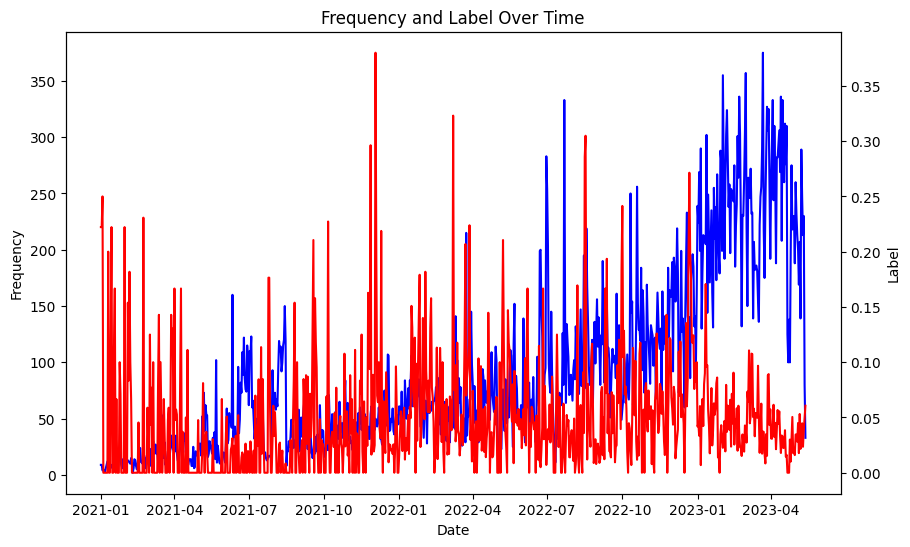

In [18]:
import matplotlib.pyplot as plt

# Convert 'created_at' column to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Group df by time intervals and calculate the frequency and label statistics
time_freq_label = df.groupby(pd.Grouper(key='created_at', freq='D')).agg({'label': 'mean', 'created_at': 'count'}).rename(columns={'created_at': 'frequency'})

# Plotting line plot with frequency and label
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(time_freq_label.index, time_freq_label['frequency'], color='blue')
ax2.plot(time_freq_label.index, time_freq_label['label'], color='red')

ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Label')

ax1.set_title('Frequency and Label Over Time')

plt.show()


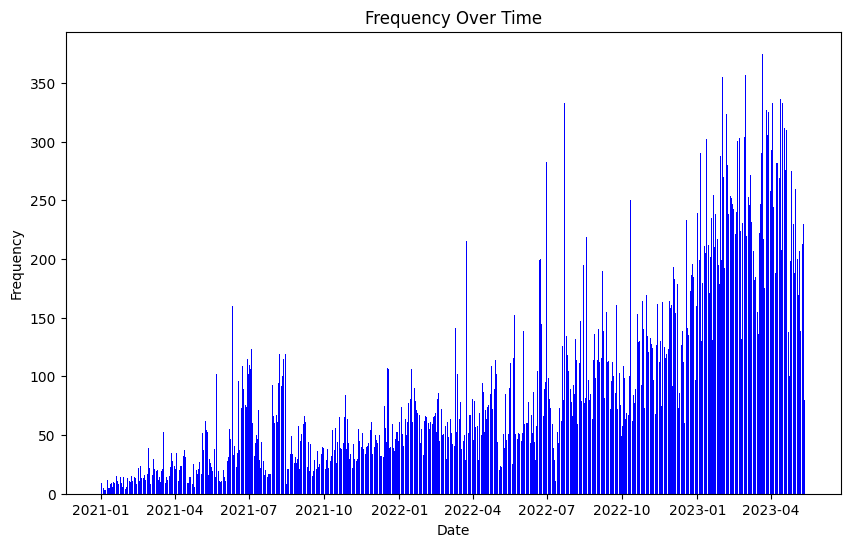

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(time_freq_label.index, time_freq_label['frequency'], color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Frequency Over Time')

plt.show()


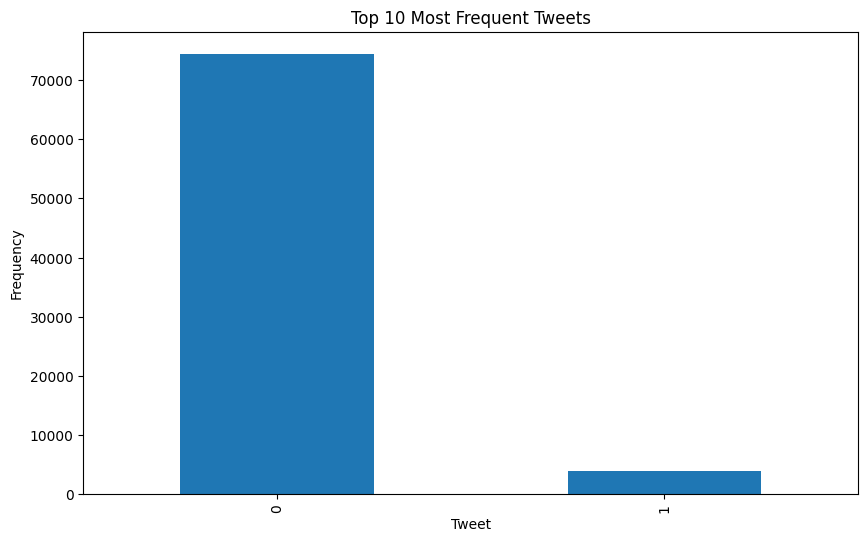

In [21]:
import matplotlib.pyplot as plt

# Find the most frequent tweets
top_tweets = df['label'].value_counts().head(10)

# Plotting bar chart of top tweets
plt.figure(figsize=(10, 6))
top_tweets.plot(kind='bar')
plt.xlabel('Tweet')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tweets')

plt.show()


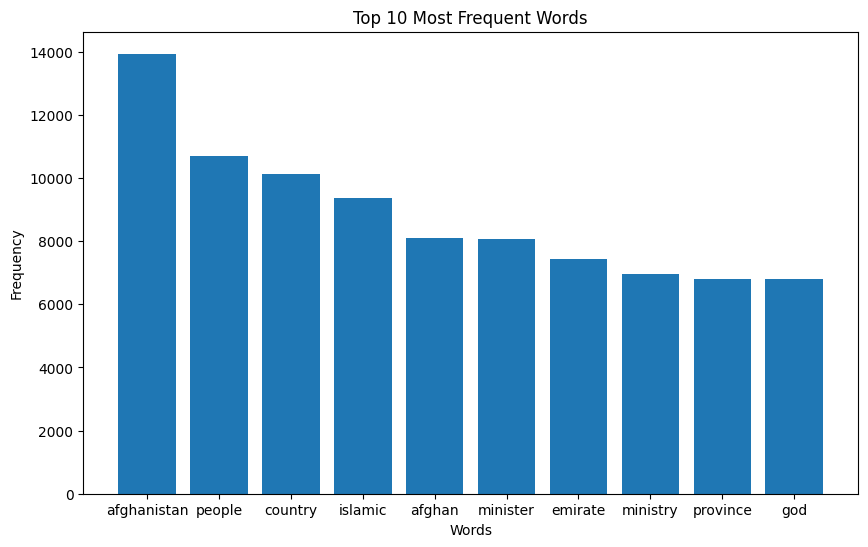

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate word frequencies
word_counts = Counter(" ".join(df['processed_text']).split())
top_words = word_counts.most_common(10)  # Top 10 most frequent words

# Plotting bar chart of word frequencies
plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words')

plt.show()


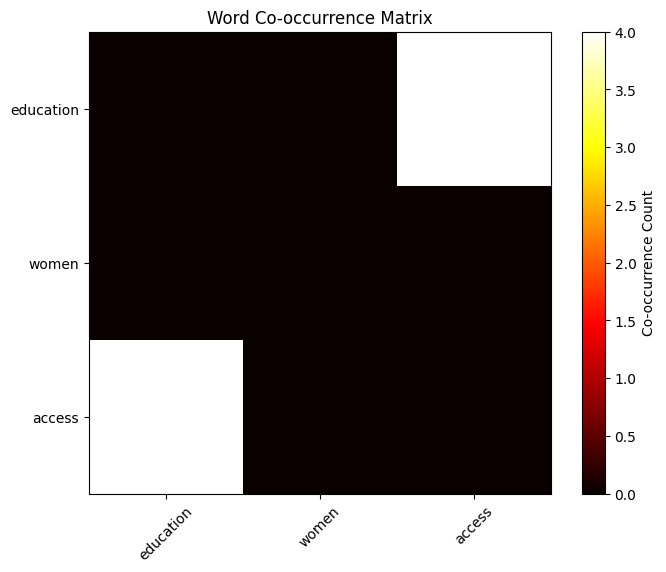

In [24]:
import numpy as np

# Define the words of interest
words_of_interest = ['education', 'women', 'access']

# Calculate the co-occurrence matrix
co_occurrence_matrix = np.zeros((len(words_of_interest), len(words_of_interest)), dtype=int)
for text in df['processed_text']:
    tokens = text.split()
    for i, word1 in enumerate(words_of_interest):
        if word1 in tokens:
            for j, word2 in enumerate(words_of_interest):
                if word2 in tokens and word2 != word1:
                    co_occurrence_matrix[i, j] += 1

# Plotting co-occurrence matrix
plt.figure(figsize=(8, 6))
plt.imshow(co_occurrence_matrix, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(len(words_of_interest)), words_of_interest, rotation=45)
plt.yticks(np.arange(len(words_of_interest)), words_of_interest)
plt.colorbar(label='Co-occurrence Count')
plt.title('Word Co-occurrence Matrix')

plt.show()


In [27]:
from nltk import ngrams
from collections import Counter
all_text = ' '.join(df['processed_text'])

# Get all bi-grams from the preprocessed text
bi_grams = list(ngrams(all_text.split(), 2))

# Count the occurrence of each bi-gram
bi_gram_counts = Counter(bi_grams)

# Display the top 10 most common bi-grams
top_bi_grams = bi_gram_counts.most_common(10)
for bi_gram, count in top_bi_grams:
    print('Bi-gram:', bi_gram, '\tCount:', count)


Bi-gram: ('islamic', 'emirate') 	Count: 6069
Bi-gram: ('foreign', 'affair') 	Count: 3472
Bi-gram: ('may', 'god') 	Count: 2349
Bi-gram: ('minister', 'foreign') 	Count: 1912
Bi-gram: ('emirate', 'afghanistan') 	Count: 1741
Bi-gram: ('amir', 'khan') 	Count: 1675
Bi-gram: ('ministry', 'foreign') 	Count: 1501
Bi-gram: ('acting', 'minister') 	Count: 1438
Bi-gram: ('god', 'bless') 	Count: 1256
Bi-gram: ('information', 'culture') 	Count: 1240


In [28]:
from gensim import models, corpora

# Create a dictionary from the preprocessed text
dictionary = corpora.Dictionary(df['processed_text'].apply(lambda x: x.split()))

# Create a document-term matrix
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Display the topics
for topic_num, topic_words in lda_model.show_topics(num_topics=5, num_words=10):
    print('Topic', topic_num, ':', topic_words)


Topic 0 : 0.023*"people" + 0.017*"country" + 0.014*"afghan" + 0.014*"islamic" + 0.012*"system" + 0.012*"taliban" + 0.011*"afghanistan" + 0.008*"nation" + 0.008*"unitedafghanistan" + 0.008*"world"
Topic 1 : 0.025*"god" + 0.017*"may" + 0.017*"allah" + 0.009*"peace" + 0.009*"friend" + 0.009*"said" + 0.009*"sahib" + 0.008*"brother" + 0.007*"good" + 0.007*"quran"
Topic 2 : 0.023*"district" + 0.019*"kandahar" + 0.019*"province" + 0.015*"kabul" + 0.014*"city" + 0.010*"area" + 0.010*"people" + 0.009*"afghani" + 0.008*"force" + 0.007*"year"
Topic 3 : 0.015*"ministry" + 0.012*"national" + 0.012*"kandahar" + 0.010*"defense" + 0.010*"muhammad" + 0.010*"th" + 0.009*"maulvi" + 0.009*"information" + 0.008*"mujahid" + 0.008*"sahib"
Topic 4 : 0.040*"afghanistan" + 0.023*"minister" + 0.020*"country" + 0.017*"emirate" + 0.017*"islamic" + 0.016*"foreign" + 0.015*"afghan" + 0.013*"affair" + 0.012*"meeting" + 0.011*"ministry"


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Compute sentiment scores for each tweet
df['sentiment_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
